In [618]:
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

# for contours
import scipy.optimize as so
#phoutils isophote
from Snap_Copy1 import dvectors, deriv, graph
from graphs import create_graph2, RotateFrame
import os


My Topic: 
        Mass loss of dark matter and changes to the 
        internal dark matter profile of halos


Question that I am trying to answer:
        What is the #D shape of the dark matter distribution of M33 - 
        how does this change with time? Is it elongated/ellipsoid or spherical?
        what do terms like prolate, oblate, or triaxal halos mean


Right now I am focusing on determining what snapshots represent M33 at
its apecenter, pericenter, and midpoints in its orbit during the orbit
around M31
I have also made a first attempt at graphing those contour diagrams




I need to create a code meant to evaluate how the dark matter halo of the
M33 Galaxy evolves.
In order to do this, I am going to be looking a contour fitting of the dark matter halo,
as well as making density profiles of the dark matter in the galaxy.

I am going to be looking at several different snapshots during important moments of the merger. 
With this, I will be able to examine theevolution of M33.



First, I need to determine the points during the merger that I would like to look at
To start, I am going to look at a couple the pericenters and apocentes of M33s dark matter halo
in order to determine the snapshots that I would like to graph



# Snaps

In [620]:
"""
Here I am loading in the data that was calculated during homework 6
to get the position of M33 and M31 at several different points in time
"""
dataM31 = np.genfromtxt("orbit_M31.txt",dtype=None,names=True)
dataM33 = np.genfromtxt("orbit_M33.txt",dtype=None,names=True)

In [622]:
M3133 = dvectors(dataM31,dataM33)

In [624]:
dist, vel, time = M3133

In [626]:
#a,at,p,pt,index,points,points_t,an,pn = deriv(dist,vel,time)
apo_snaps, peri_snaps, mid_snaps, at, pt = deriv(dist,vel,time)

In [628]:
print(pt)

[ 0.928571  4.285714  6.714286  8.285714  9.571429 10.571429]


Below is a graph meant to test the deriv function is properly returning the apocenter and pericenter times. (It does, yay)

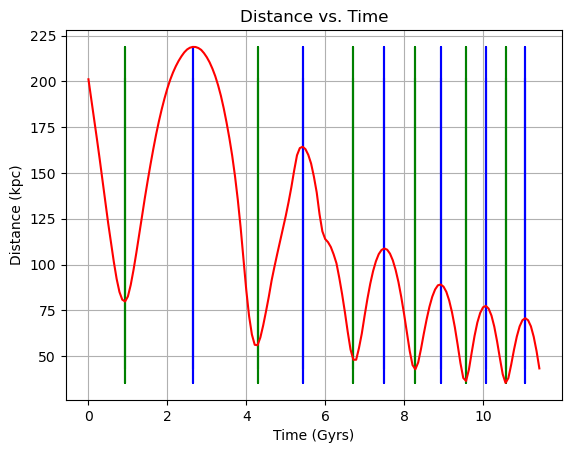

In [27]:
graph(M3133[0],M3133[2],pt,at)

Now I have narrowed down the most important snaps to these:

In [30]:
print (f"the apo snaps are {apo_snaps}")
print (f"the peri snaps are {peri_snaps}")
print (f"the midpoint snaps are {mid_snaps}")
print ('the initial snap is 000')

the apo snaps are [185. 380. 525. 625. 705. 775.]
the peri snaps are [ 65. 300. 470. 580. 670. 740.]
the midpoint snaps are [ 95. 105. 200. 205. 280. 285. 335. 335. 375. 380. 415.]
the initial snap is 000


# Figure 1

From this point on, I am going to be looking at 4 snap points

snap 000: because it is at the start

snap 300: it is a pericenter point relativley close to the time that M31 and MW merge

snap 380: it is an apocenter point shortly after the time that M31 and MW merge

snap 705: it is an apocenter point far after the time that M31 and MW merge

In [422]:
# Define theses snaps to a list
snaps = np.array([000,300,380,705])

The distance between the two galaxies at each snap are:

In [37]:
#print (dist[0])
r = np.zeros(len(snaps))
for i in range(len(snaps)):
    r[i] = (dist[int(snaps[i]/5)])
    print (f'{r[i]} kPc at snap number {snaps[i]}')

201.1212144454185 kPc at snap number 0
55.959157427538166 kPc at snap number 300
164.2910542299854 kPc at snap number 380
77.41712794982773 kPc at snap number 705


Now I need to define the analytical jacobi radius between the two galaxies at each of these points

In [466]:
def jacobi_radius (snaps,m,M):
    """
    This function returns a list with the jacobi radius for each snap that I am using
    inputs:
        snaps ('np.ndarray'): the snapshots of the galaxies that I am using
        m ('int'): The mass of the satellite galaxy in 1e10 Msun
        M ('int'): The mass of the larger galaxy 1e10 Msun
    outputs:
        jacobi ('np.ndarray'): contains the jacobi radius at each snapshot
    """
    
    r = np.zeros(len(snaps)) # Gets the distances between the two galaxies at each snap
    for i in range(len(snaps)):
        r[i] = (dist[int(snaps[i]/5)])
    jacobi = r*(m/(2*M))**(1/3) # plugs the distances into the analytical jacobi radius equation
    return jacobi

In [42]:
# Get mass values to use for jacobi radius function


time, total, dataM = Read('M31_000.txt') # Loads in data for M31 at snapshot zero
time, total, datam = Read('M33_000.txt') # Loads in data for M31 at snapshot zero
# Narrows our data down to specific parcicle types thorugh indexing
indexM = np.where(dataM['type'] == 1)
indexm = np.where(datam['type'] == 1)
M_halo = dataM[indexM]
m_halo = datam[indexm]
# Sums up the total mass of halo particles in each galaxy
M = np.sum(M_halo['m'])
m = np.sum(m_halo['m'])
print (f'M is {M}')
print (f'm is {m}')

M is 192.08800000000002
m is 18.6613


In [478]:
# runs jacobi_radius to get the jacobi radius at each snapshot
jac = jacobi_radius(snaps,m,M)
print (jac)

[73.38293948 20.4177738  59.94474787 28.24712664]


Now I have the data that I need to graph my first figure

In [598]:
def mass_prof(filename,ptype):
    """
    This function implements create_graph2, and RotateFrame to return the coordinates of a particle of a specified type in
    a new coordinate system around the center of mass and rotational axis of the galaxy.
    inputs:
        filename ('string'): the name of the file for the galaxy snap that we are looking at
        ptype ('int'): the particle type
    outputs:
        rn ('np.array'): value from the rotate frame function that contains the position of the particles in the rotated
            coordinate system.
        mnew ('np.array'): contains the mass of each particle of the specified particle type in the file
    """
    
    time, total, data = Read(filename) # Loads in the data
    
    # Uses create_graph2 to get the particle positions and velocities for each particle of the 
    # specified type in terms of the center of mass of the system
    pos, vel = create_graph2(filename,ptype) 
    rn, vn = RotateFrame(pos,vel) # rotates the coordinate system to match the galaxies axis of rotation
    m, t = data['m'],data['type'] # Creates arrays for particle mass and particle type
    index = np.where(t == ptype) # uses the above arrays to exclude particle types that we don't care about through indexing
    mnew = m[index]
    return (rn,mnew)

In [600]:
def mass_profile(r_int, m, radii,direction,jacobi):
    """
    This function creates an enclosed mass profile using cyindrical coordinates, as opposed to spherical
    This will help me determine the shape of the halo
        inputs:
            r_int ('np.ndarray'): the array of radii lengths to include in the graphs
            m ('np.ndarray'): an array containing the mass of each particle
            radii ('np.ndarray'): an array containing the positions of each particle
            direction ('string'): the axis that we are expanding the cylander around (either the x, y, or z axis)
            jacobi ('float'): the jacobi radius at this snap
        outputs: 
            total_mass ('np.ndarray'): an array containing the total mass enclosed within reach radius from r_int up to the jacobi radius
            mtotal ('float'): the total mass enclosed within the highest r value (also equals the last value in total_mass)
    """
    # This part limits the particle positions to their positions on a
    # 2D plane around the direction axis
    # c and d are the indices representing axis
    if direction == 'x':
        c = 1
        d = 2
    if direction == 'y':
        c = 0
        d = 2
    if direction == 'z':
        c = 0
        d = 1
    c_value = np.abs(radii[:,c]) # creates an array containing the coorinates for each particle along one axis
    d_value = np.abs(radii[:,d]) # creates an array containing the coorinates for each particle along one axis
    r_jacobi = np.where(r_int<jacobi) # Limits r_int to explude values greater than the jacobi radius
    r_int_jacobi = r_int[r_jacobi]
    total_mass = np.zeros(len(r_int_jacobi))
    for R in range(len(total_mass)): # gets the total mass within a radius of the cylander
        within = np.where((c_value<r_int_jacobi[R])&(d_value<r_int_jacobi[R]))
        total_mass[R] = (np.sum(m[within])) # assigns the total mass to an array containing the total mass enclosed withn each radius in r_int_jacobi
        
    mtotal = total_mass[int(len(total_mass)-1)] # gets the total mass enclosed in the cylander equal to the jacobi radius
    return total_mass, mtotal

In [602]:
def MassProfileplt3(r_int, m, radii,jaco):
        """
        Makes a plot of the cylyndrical mass profile for each axis, stopping at the analytical jacobi
        radius for that snapshot
        inputs:
            r_int ('np.ndarray'): the array of radii to include in the graphs
            m ('np.ndarray'): The mass of each particle
            radii ('np.ndarray'): The positions of each particle
        """
        # gets the arrays containing mass enclosed at different radii within the jacob radius
        # also gets the mass enclosed at the jacobi radius
        x, mtx = mass_profile(r_int,m,radii,'x',jaco)
        y, mty = mass_profile(r_int,m,radii,'y',jaco)
        z, mtz = mass_profile(r_int,m,radii,'z',jaco)
        index = np.where(r_int<jaco) # limits the radii in r_int to ones smaller than the jacobi radius
        i = r_int[index]
        # plots the mass enclosed within the cylanders as a function of radius
        plt.plot(i, x, color='blue', 
         linewidth=5, label='x')
        plt.plot(i, y, color='red', 
         linewidth=5, label='y')
        plt.plot(i, z, color='green', 
         linewidth=5, label='z')
        # Labels the graph
        plt.xlabel('Radius',fontsize = 22)
        plt.ylabel('Mass', fontsize = 22)
        plt.legend()
        plt.show()
        # prints a statment that tells us how much mass is within each cylander at the jacobi radius
        print (f"Hits enclosed mass of {mtx} along the x axis at jacobi radius {jaco}")
        print (f"Hits enclosed mass of {mty} along the y axis at jacobi radius {jaco}")
        print (f"Hits enclosed mass of {mtz} along the z axis at jacobi radius {jaco}")
        return (mtx,mty,mtz)
        

Now we can run the code to create the graphs

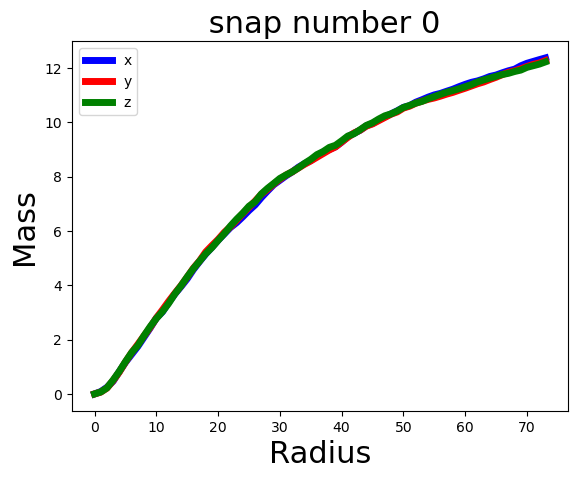

Hits enclosed mass of 12.372441900000002 along the x axis at jacobi radius 73.38293948405119
Hits enclosed mass of 12.275403140000002 along the y axis at jacobi radius 73.38293948405119
Hits enclosed mass of 12.226883760000002 along the z axis at jacobi radius 73.38293948405119


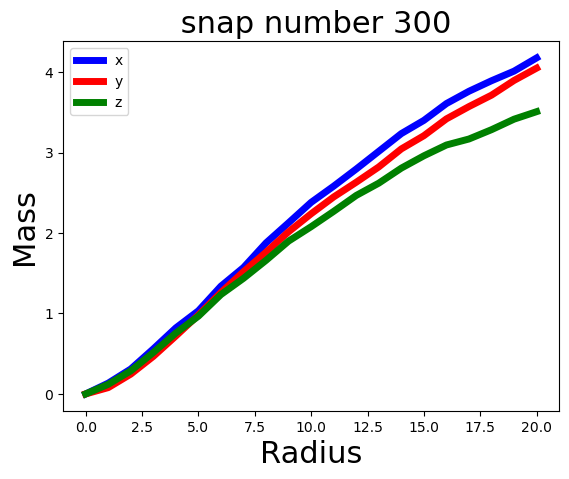

Hits enclosed mass of 4.176401178000001 along the x axis at jacobi radius 20.41777380077406
Hits enclosed mass of 4.04950427 along the y axis at jacobi radius 20.41777380077406
Hits enclosed mass of 3.5083262800000004 along the z axis at jacobi radius 20.41777380077406


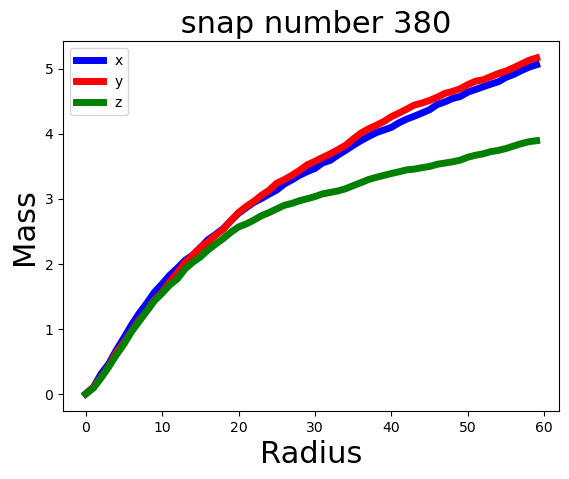

Hits enclosed mass of 5.060947272 along the x axis at jacobi radius 59.944747865481226
Hits enclosed mass of 5.165450608 along the y axis at jacobi radius 59.944747865481226
Hits enclosed mass of 3.892749266 along the z axis at jacobi radius 59.944747865481226


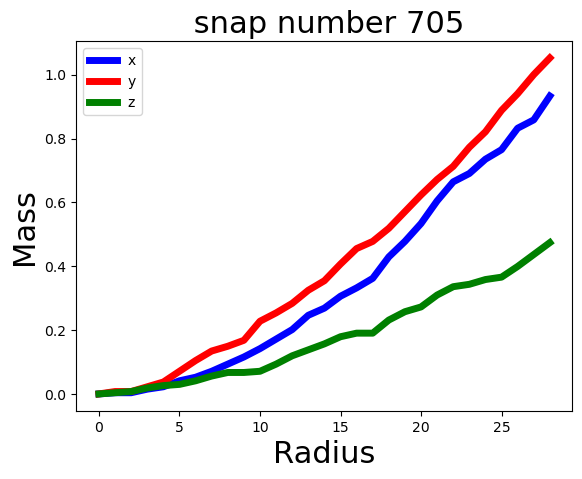

Hits enclosed mass of 0.9330655 along the x axis at jacobi radius 28.24712664467839
Hits enclosed mass of 1.052497884 along the y axis at jacobi radius 28.24712664467839
Hits enclosed mass of 0.4739972739999999 along the z axis at jacobi radius 28.24712664467839


In [576]:
galaxy = 'M33'
for i in range(len(snaps)):
    # Turns the snap number into its filename
    ilbl = '000' + str(snaps[i])
    ilbl = ilbl[-3:]
    filename = "%s_"%(galaxy) + ilbl+ '.txt'
    rn, mnew = mass_prof(filename,1)
    r_int = np.arange(0,500,1)  # defines our array of radii to look at
    # Adds a header to the graph before running MassProfileplt
    plt.title(f' snap number {snaps[i]}', fontsize = 22)
    mass_profiles = MassProfileplt3(r_int,mnew,rn,jac[i])

# Figure 2

For the second Figure, I am looking at how the average particle distance from the center of mass changes over time

This is done by graphing the average particle distance over time. 

One graph represents tha particle distance in the x,y, and z axis, while the other it in terms of 
the total average particle distance

In [154]:
def avg_radius(galaxy, snaps, ptype):
    """
    This function takes a series of snapshots and makes an array representing the average particle distance
    from the center of mass of agalaxy for a specific particle type in each snapshot
    inputs:
        galaxy ('string'): The galaxy that we are looking at
        snaps ('np.ndarray'): Contains the snapshots of a galaxy that we are looking at
        ptype ('int'): the type of particle
    outputs:
        radi ('np.ndarray'): Array containing the average particle distance from the center of mass of a galaxy at each
            snapshot in snaps
    
    """
    radi = np.zeros(len(snaps)) # initializes an array containing the average particle distance from the center of mass at each snap in snaps
    for i in range(len(snaps)):
        # turns the snapshots into their corresponding filename
        ilbl = '000' + str(snaps[i])
        ilbl = ilbl[-3:]
        filename = "%s_"%(galaxy) + ilbl+ '.txt'
        file = os.path.join(galaxy,filename)
        # calls on create_graph2 to load in the particle positions and velocity data for 
        # position and velocity relative to the venter of mass
        rnt,vnt = create_graph2(file,ptype)
        # creates an array containing the distance of each particle from the 
        # center of mass within the snapshot
        r_snap = np.sqrt(rnt[:,0:1]**2+rnt[:,1:2]**2+rnt[:,2:3]**2)
        # takes the average distance and assigns it to radi
        avg_r = np.mean(r_snap)
        radi[i] = avg_r
    return(radi)

In [180]:
def avg_direction(galaxy,snaps,ptype):
    """
    This function takes a series of snapshots and makes an array representing the average particle distance
    in each direction along the xyz coordinate system from the center of mass of a galaxy for a 
    specific particle type in each snapshot.
    inputs:
        galaxy ('string'): The galaxy that we are looking at
        snaps ('np.ndarray'): Contains the snapshots of a galaxy that we are looking at
        ptype ('int'): the type of particle
    outputs:
        radi_x ('np.ndarray'): Array containing the average particle distance from the center of mass of a galaxy in the x direction at each
            snapshot in snaps.
        radi_y ('np.ndarray'): Array containing the average particle distance from the center of mass of a galaxy in the y direction at each
            snapshot in snaps.
        radi_z ('np.ndarray'): Array containing the average particle distance from the center of mass of a galaxy in the z direction at each
            snapshot in snaps.
    """
    # initializes an array containing the average particle distance from the center of mass in the x direction at each snap in snaps
    radi_x = np.zeros(len(snaps))
    # initializes an array containing the average particle distance from the center of mass in the y direction at each snap in snaps
    radi_y = np.zeros(len(snaps))
    # initializes an array containing the average particle distance from the center of mass in the z direction at each snap in snaps
    radi_z = np.zeros(len(snaps))
    for i in range(len(snaps)):
        # turns the snapshots into their corresponding filename
        ilbl = '000' + str(snaps[i])
        ilbl = ilbl[-3:]
        filename = "%s_"%(galaxy) + ilbl+ '.txt'
        file = os.path.join(galaxy,filename)
        # uses mass_prof redefine our coordinate system around the center of mass
        # and rotational axis of the galaxy
        rnt,vnt = mass_prof(file,ptype)
        # creates arrays containing the distance of each particle from the 
        # center of mass within the snapshot in the x, y, and z directions
        x_d = (np.abs(rnt[:,0:1]))
        y_d = (np.abs(rnt[:,1:2]))
        z_d = (np.abs(rnt[:,2:3]))
        # takes the average distance in the x, y, and z direction and assigns it to their respecive arrays, radi_x, radi_y, and radi_z
        avg_x = np.mean(x_d)
        avg_y = np.mean(y_d)
        avg_z = np.mean(z_d)
        radi_x[i] = avg_x
        radi_y[i] = avg_y
        radi_z[i] = avg_z
    return(radi_x,radi_y,radi_z)

In [412]:
#Defines some snaps to use to create the radius graph
snaps2 = np.arange(0,800,5)

Now we can get our data that nees to be graphed. It is worth mentioning that some value are nan due to how the COM_P and COM_V
functions for CenterOfMass are iterated. It causes the total mass to be zero, which leads to a divide by zero error.
Only a few of the selected snaps have this problem, so the graphs are both still very clear.

In [414]:
radius_avg = avg_radius('M33',snaps2,1)

In [194]:
x_avg,y_avg,z_avg = avg_direction('M33',snaps2,1)

Now I can plot this data against the snap numbers to look at how the radius is evolving with time

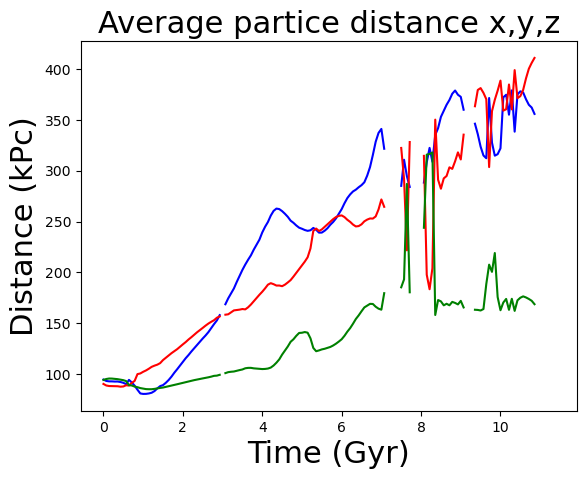

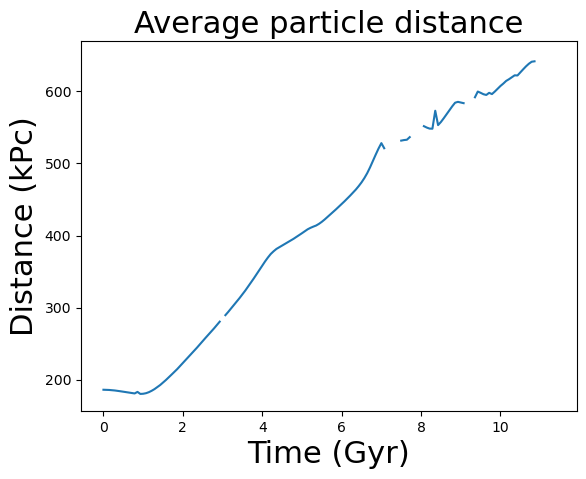

In [410]:


time = snaps2*14.2857/1000 # creates a time array that allows us to graph the average distance against time instead of snap number
plt.plot(time,x_avg, color = "blue")
plt.plot(time,y_avg, color = "red")
plt.plot(time,z_avg, color = "green")
plt.title('Average partice distance x,y,z', fontsize = 22)
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Distance (kPc)', fontsize=22)
plt.show()
plt.title('Average particle distance', fontsize = 22)
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Distance (kPc)', fontsize=22)

plt.plot(time,radius_avg)

# Figure 3

In [604]:
def MassProfileplt4(r_int, m, radii,jaco):
        """
        Returns the mass enclosed within the jacobi radius for the cylindrical enclosed mass profiles centered around
        each axis.
        inputs:
            r_int ('np.ndarray'): The array of radii to include in the graphs.
            m ('np.ndarray'): An array containing the mass of each particle.
            radii ('np.ndarray'): An array containing the position of each particle.
            jaco ('float'): The jacobi radius.
        outputs:
            x_enc_tot ('float'): The mass enclosed at the jacobi radius for the cylander centered around the x axis
            y_enc_tot ('float'): The mass enclosed at the jacobi radius for the cylander centered around the y axis
            z_enc_tot ('float'): The mass enclosed at the jacobi radius for the cylander centered around the z axis
        """
        #index = np.where(r_int<jaco)
        #i = r_int[index]
        x_enc, x_enc_tot = mass_profile(r_int,m,radii,'x',jaco)
        y_enc, y_enc_tot = mass_profile(r_int,m,radii,'y',jaco)
        z_enc, z_enc_tot = mass_profile(r_int,m,radii,'z',jaco)
        return (x_enc_tot,y_enc_tot,z_enc_tot)
        

In [612]:
def jacobi_mass_evolution(r_int,snap):
    """
    This function takes the enclosed mass within the jacobi radius of the cylanders and 
    graphs them against eachother to see how they compare over time.
    Since the jacobi radius is evolving throughout the simulation, we need to account for this by
    looking at the percentage of the combined mass enclosed within the cylanders, and graphing the percentage
    of that mass contained within each cylander. This way, we can clearly look at how the enclosed mass within each cylander evolves
    with a function of time realtive to the other 2 cylanders.
    """
    galaxy = 'M33'
    # initializes an array containing the mass enclosed within the jacobi radius the cylander along the x axis for each snap in snaps
    enc_x = np.zeros(len(snap)) 
    # initializes an array containing the mass enclosed within the jacobi radius the cylander along the y axis for each snap in snaps
    enc_y = np.zeros(len(snap))
    # initializes an array containing the mass enclosed within the jacobi radius the cylander along the z axis for each snap in snaps
    enc_z = np.zeros(len(snap))
    jac = jacobi_radius(snap,m,M) # gets the enclosed mass within the Jacobi radius for each cylander at each snap
    
    for i in range(len(snap)):
        # converts snap number to filename
        ilbl = '000' + str(snap[i])
        ilbl = ilbl[-3:]
        filename = "%s_"%(galaxy) + ilbl+ '.txt'
        file = os.path.join(galaxy,filename)
        rn, mnew = mass_prof(file,1) # adjusts the coordinate system
        mtx,mty,mtz = MassProfileplt4(r_int,mnew,rn,jac[i]) # gets the enclosed mass along each axis at the jacobi radius
        # assigns the enclosed mass values to an array containing the enclosed
        # mass values for each snapshot being read
        enc_x[i] = mtx # assigns the enclosed mass x value to enc_x
        enc_y[i] = mty # assigns the enclosed mass y value to enc_y
        enc_z[i] = mtz # assigns the enclosed mass z value to enc_z
    # puts the arrays together
    enc_r = enc_x,enc_y,enc_z
    enc = np.array(enc_r)
    enc_t = enc_x+enc_y+enc_z # gets the combined mass encluded within the arrays
    x_per = enc_x/enc_t # divides enc_x by the combined mass to turn each value into a value representing the parcentage of the combined mass
    y_per = enc_y/enc_t # divides enc_y by the combined mass to turn each value into a value representing the parcentage of the combined mass
    z_per = enc_z/enc_t # divides enc_z by the combined mass to turn each value into a value representing the parcentage of the combined mass
    time = snap*14.2857/1000 # creates a time array that allows us to graph the average distance against time instead of snap number
    # plots the percentage values as a function of time
    plt.plot(time,x_per,color = "blue")
    plt.plot(time,y_per,color = "red")
    plt.plot(time,z_per, color = "green")
    plt.title("Enclosed Mass Over Time", fontsize = 20)
    plt.xlabel("Snap",fontsize = 20)
    plt.ylabel('Mass Enclosed = (1^10 Msun)', fontsize = 20)

In [614]:
# The jacobi radius for each snap in r_int
jac2 = jacobi_radius(snaps2,m,M)

C:\Users\colin\AppData\Local\Temp\ipykernel_26584\1384810629.py:36: RuntimeWarning: invalid value encountered in divide
  x_per = enc_x/enc_t # divides enc_x by the combined mass to turn each value into a value representing the parcentage of the combined mass
C:\Users\colin\AppData\Local\Temp\ipykernel_26584\1384810629.py:37: RuntimeWarning: invalid value encountered in divide
  y_per = enc_y/enc_t # divides enc_y by the combined mass to turn each value into a value representing the parcentage of the combined mass
C:\Users\colin\AppData\Local\Temp\ipykernel_26584\1384810629.py:38: RuntimeWarning: invalid value encountered in divide
  z_per = enc_z/enc_t # divides enc_z by the combined mass to turn each value into a value representing the parcentage of the combined mass


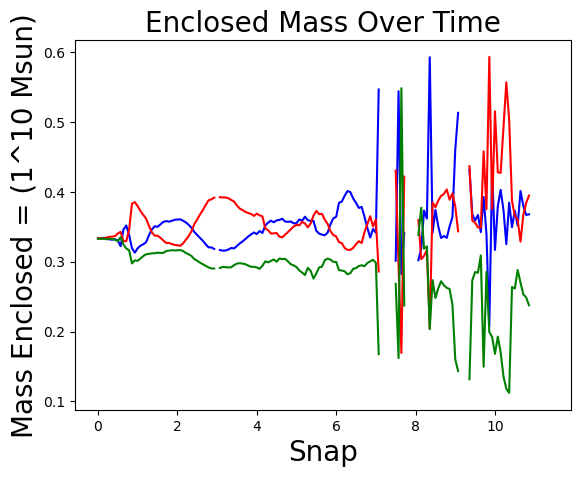

In [616]:
jacobi_mass_evolution(r_int,snaps2)